In [173]:
import pandas as pd
import numpy as np
import chess
import chess.engine
import re
import matplotlib.pyplot as plt

In [170]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [133]:
# Load the dataset from the image file
data = pd.read_csv(r'C:\Users\Admin\AIP\tactic_evals.csv')

In [138]:
data.head()

,FEN,Evaluation,Move
0,r2qkbr1/pb1nn3/1ppp3p/8/3P1p2/2PB1N1P/PPQN1PP1...,#+2,d3g6
1,r2qkb2/pb1nn3/1ppp2rp/8/3P1p2/2P2N1P/PPQN1PP1/...,#+1,c2g6
2,r2qkbr1/pb1nn3/1ppp2Bp/8/3P1p2/2P2N1P/PPQN1PP1...,#+1,g8g6
3,8/7p/R5p1/2p1pkP1/7P/P4PK1/1r6/3q4 w - - 6 46,#+1,a6f6
4,6k1/pp6/3p4/2p1p3/2P1P1q1/1P1P2pP/P5P1/5K2 w -...,+408,h3g4


# FEN Notation to Vector
    #piece placement - lowercase for black pieces, uppercase for white pieces. numbers represent consequtive spaces. / represents a new row 
    # active color - whose turn it is, either 'w' or 'b'
    # castling rights - which castling moves are still legal K or k for kingside and Q or q for queenside, '-' if no legal castling moves for either player
    # en passant - if the last move was a pawn moving up two squares, this is the space behind the square for the purposes of en passant
    # halfmove clock - number of moves without a pawn move or piece capture, after 50 of which the game is a draw
    # fullmove number - number of full turns starting at 1, increments after black's move

In [141]:
import numpy as np
import re
import chess

def fen_to_bit_vector(fen):
    parts = re.split(" ", fen)
    piece_placement = re.split("/", parts[0])
    active_color = parts[1]
    castling_rights = parts[2]
    en_passant = parts[3]
    halfmove_clock = int(parts[4])
    fullmove_clock = int(parts[5])

    bit_vector = np.zeros((14, 8, 8), dtype=np.uint8)

    # piece to layer structure taken from reference [1]
    piece_to_layer = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }

    for r, row in enumerate(piece_placement):
        c = 0
        for piece in row:
            if piece in piece_to_layer:
                bit_vector[piece_to_layer[piece], r, c] = 1
                c += 1
            else:
                c += int(piece)

    # Encode castling rights in a specific layer (layer 12)
    castling_positions = {'K': (7, 7), 'Q': (7, 0), 'k': (0, 7), 'q': (0, 0)}
    for right in castling_rights:
        if right in castling_positions:
            bit_vector[12, castling_positions[right][0], castling_positions[right][1]] = 1

    # Encode en passant square (layer 13)
    if en_passant != '-':
        en_passant_index = chess.parse_square(en_passant)
        ep_row, ep_col = np.unravel_index(en_passant_index, (8, 8))
        bit_vector[13, 7 - ep_row, ep_col] = 1

    return bit_vector

In [142]:
def standardize_evaluation(value, min_value, max_value):
    try:
        value = float(value)
    except ValueError:
        cleaned_value = value.lstrip('#')
        try:
            numeric_value = float(cleaned_value)
            value = numeric_value * 15000
        except ValueError:
            print("cannot clean")
    standardized_value = (value - min_value) / (max_value - min_value)
    return standardized_value

In [143]:
def square_to_index(square):
    letter = chess.square_name(square)
    row = 8 - int(letter[1])
    column = board_positions[letter[0]]
    return row, column

In [144]:
def boards_to_matrices_batch(boards):
    batch_size = len(boards)
    board_3d_batch = np.zeros((batch_size, 14, 8, 8), dtype=np.int8)

    for b_idx, board in enumerate(boards):
        for piece in chess.PIECE_TYPES:
            for square in board.pieces(piece, chess.WHITE):
                index = np.unravel_index(square, (8, 8))
                board_3d_batch[b_idx, piece - 1, 7 - index[0], index[1]] = 1
            for square in board.pieces(piece, chess.BLACK):
                index = np.unravel_index(square, (8, 8))
                board_3d_batch[b_idx, piece + 5, 7 - index[0], index[1]] = 1

        aux = board.turn
        board.turn = chess.WHITE
        for move in board.legal_moves:
            i, j = np.unravel_index(move.to_square, (8, 8))
            board_3d_batch[b_idx, 12, 7 - i, j] = 1

        board.turn = chess.BLACK
        for move in board.legal_moves:
            i, j = np.unravel_index(move.to_square, (8, 8))
            board_3d_batch[b_idx, 13, 7 - i, j] = 1

        board.turn = aux

    return board_3d_batch

In [150]:
def process_batch(batch):
    valid_rows = batch.dropna(subset=['FEN', 'Evaluation'])
    y_evaluation = valid_rows['Evaluation'].apply(standardize_evaluation, args=(-10000, 10000)).values

    feature_boards = []
    for fen in valid_rows['FEN']:
        bit_vector = fen_to_bit_vector(fen)
        feature_boards.append(bit_vector)
    
    feature_board = np.stack(feature_boards, axis=0)
    return feature_board, y_evaluation

In [151]:
feature_board, y_evaluation = process_batch(data)

In [152]:
print("Feature board shape:", feature_board.shape)
print("Evaluations shape:", y_evaluation.shape)

Feature board shape: (2628219, 14, 8, 8)
Evaluations shape: (2628219,)


In [165]:
def create_model(input_shape):
    model = models.Sequential([
          layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
          layers.MaxPooling2D(pool_size=(2, 2)),
          layers.Flatten(),
          layers.Dense(128, activation='relu'),
          layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid for advantage score
      ])

    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    return model

# Create and compile the model
model = create_model(input_shape)


In [166]:
# Assuming you have your training data prepared as bit vectors and advantage scores
X_train, X_test, y_train, y_test = train_test_split(feature_board, y_evaluation, test_size=0.2, random_state=42)  

# Get input shape from training data
input_shape = X_train.shape[1:]

In [176]:
model = create_model(input_shape)
history=model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 458s 7ms/step - loss: 0.0935 - mse: 0.0935 - val_loss: 0.0889 - val_mse: 0.0889
Epoch 2/10
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 394s 6ms/step - loss: 0.0880 - mse: 0.0880 - val_loss: 0.0885 - val_mse: 0.0885
Epoch 3/10
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 439s 7ms/step - loss: 0.0861 - mse: 0.0861 - val_loss: 0.0875 - val_mse: 0.0875
Epoch 4/10
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 373s 6ms/step - loss: 0.0851 - mse: 0.0851 - val_loss: 0.0867 - val_mse: 0.0867
Epoch 5/10
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 550s 8ms/step - loss: 0.0854 - mse: 0.0854 - val_loss: 0.0868 - val_mse: 0.0868
Epoch 6/10
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 577s 9ms/step - loss: 0.0846 - mse: 0.0846 - val_loss: 0.0862 - val_mse: 0.0861
Epoch 7/10
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 1066s 16ms/step - loss: 0.0831 - mse: 0.0831 - val_loss: 0.0868 - val_mse: 0.0868
Epoch 8/10
65706/65706 ━━━━━━━━━━━━━━━━━━━━ 815s 12ms/step - loss: 0.0845 - mse: 0.0845 - val_loss: 0.0867 - val_mse: 0.0867
Epoch

In [168]:
# Evaluate the model on the test set
loss, mae = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", loss)
print("Test Mean Absolute Error (MAE):", mae)

16427/16427 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 0.0860 - mse: 0.0860
Test Loss (MSE): 0.08653480559587479
Test Mean Absolute Error (MAE): 0.08652818948030472


In [171]:
# Predict the evaluations on the test set
y_pred = model.predict(X_test)

# Calculate additional metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Test Mean Squared Error (MSE):", mse)
print("Test Mean Absolute Error (MAE):", mae)

16427/16427 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step
Test Mean Squared Error (MSE): 0.0865283921490882
Test Mean Absolute Error (MAE): 0.11756262653893428


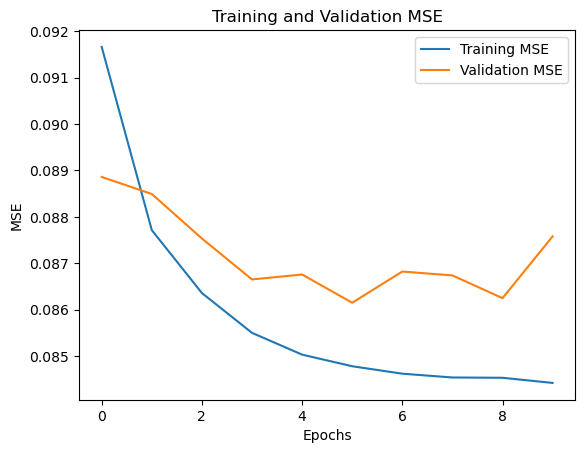

In [177]:
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [178]:
fen = 'r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 4'

# Preprocess the FEN string
bit_vector = fen_to_bit_vector(fen)
bit_vector = np.expand_dims(bit_vector, axis=0)  # Add batch dimension

# Predict the evaluation
predicted_evaluation = model.predict(bit_vector)
print(f"Predicted Evaluation: {predicted_evaluation[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted Evaluation: 0.5018922090530396


References
https://www.kaggle.com/code/utadcm0927/chess-position-evaluator